<a href="https://colab.research.google.com/github/Lotfullah21/Algorithms_AI/blob/main/Neuron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [257]:
import math

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [258]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [259]:
import torch
import random 

In [260]:

a = torch.Tensor([3.0]).double()           ; a.requires_grad = True
b = torch.Tensor([4.0]).double()           ; b.requires_grad = True
bias = torch.Tensor([4.4340]).double()     ; bias.requires_grad = True
w1 = torch.Tensor([4.0]).double()          ; w1.requires_grad = True
w2 = torch.Tensor([-5.0]).double()         ; w2.requires_grad = True
s = a*w1 + b*w2 + bias 

o = torch.tanh(s)
o.backward()

print("output\n",o.item(),"\n")

print("a", a.grad.item())
print('b', b.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

output
 -0.9984030370174252 

a 0.012765502697527818
b -0.015956878371909775
w1 0.009574127023145864
w2 0.012765502697527818


In [261]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [262]:
class Neuron:
  
  def __init__(self,n_input):
    self.w = [Value(random.uniform(-1,1)) for _ in range(n_input)]
    self.b =  Value(random.uniform(-1,1))
  
  def __call__(self,x):
    # w*x + b, we use zip to multiply it pairwise
    #  act = sum((wi*xi for wi, xi in zip(self.w, x)), 0.0) + self.b
    summation = sum((w*x for w,x in zip(self.w, x)), self.b)  # sum gets the starting argument to start with as well, we passed self.b as_starting
    out = summation.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self,n_input,n_output):
    self.neurons = [Neuron(n_input) for _ in range(n_output)]
  
  def __call__(self,x):
    out = [n(x) for n in self.neurons]
    return out[0] if len(out)==1 else out

  def parameters(self):
    params = []
    for neuron in self.neurons:
      param = neuron.parameters()
      params.extend(param)
    return params


class MLP:

  def __init__(self, n_input, n_outputs):
    size = [n_input] + n_outputs
    self.layers = [Layer(size[i],size[i+1]) for i in range(len(n_outputs))]
  
  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      param = layer.parameters()
      params.extend(param)
    return params



In [263]:

x = [3,32,1,3]
n = MLP(4,[4,4,1])
n(x)

Value(data=-0.13523090182052042)

In [264]:
n.parameters()


[Value(data=-0.09298773854438269),
 Value(data=-0.6834195878001899),
 Value(data=-0.032061740552117524),
 Value(data=0.8194791594000848),
 Value(data=-0.8798185288138853),
 Value(data=0.4134699078329023),
 Value(data=-0.7611372000147061),
 Value(data=-0.734008319862508),
 Value(data=0.349862074356698),
 Value(data=-0.9983098316141943),
 Value(data=0.20028335278214726),
 Value(data=-0.34766655264817437),
 Value(data=0.6214927356102722),
 Value(data=0.7237250851152841),
 Value(data=0.7494154536093387),
 Value(data=0.7269724986917212),
 Value(data=0.3610507908689764),
 Value(data=0.7794561550659416),
 Value(data=-0.055191718372320064),
 Value(data=-0.4904889801063492),
 Value(data=0.5672702141677193),
 Value(data=-0.07830264772615769),
 Value(data=-0.6757636447592479),
 Value(data=0.021185171455541774),
 Value(data=-0.6499730357802957),
 Value(data=0.3180720777285464),
 Value(data=0.9067325092512846),
 Value(data=-0.8747457007934101),
 Value(data=-0.08180264626301303),
 Value(data=-0.5754

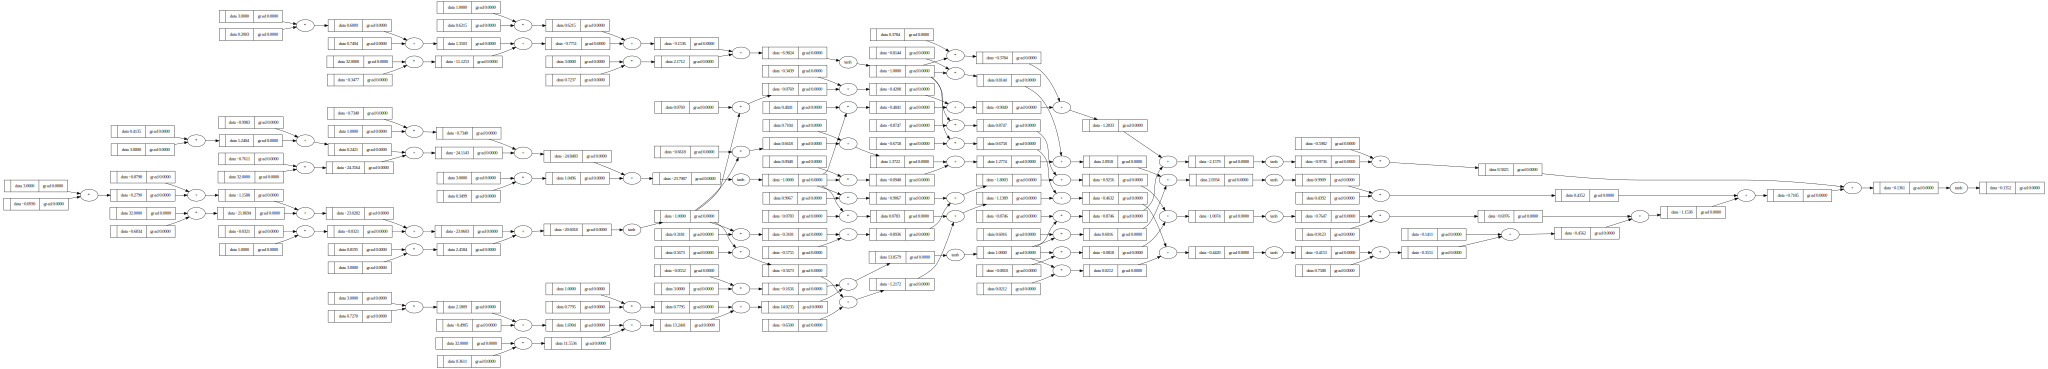

In [265]:
draw_dot(n(x))

In [266]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_pred = [n(x) for x in xs]
loss = sum((y_cal - y_true)**2 for y_true, y_cal in zip(ys,y_pred))

In [267]:
n.layers[0].neurons[1].w[1].data

-0.7611372000147061

In [268]:
n.layers[0].neurons[1].w[1].grad  

0.0

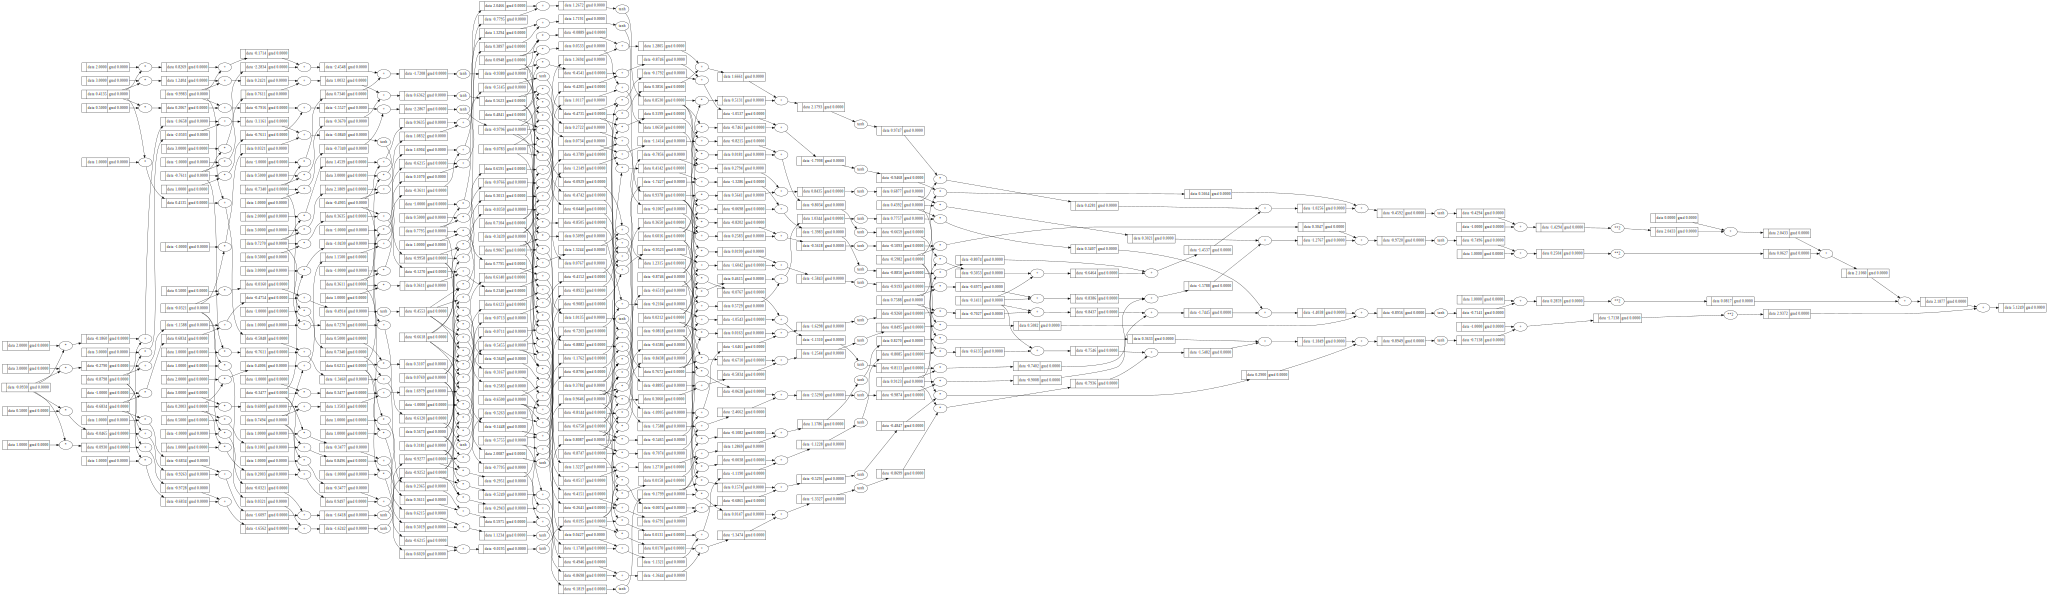

In [269]:
draw_dot(loss)

In [270]:
n.layers[0].neurons[1].w[1].data

-0.7611372000147061

In [271]:
n.layers[0].neurons[1].w[1].grad

0.0

In [290]:
# New loss after moving the vector against  direction of gradient
# forward pass
y_pred = [n(x) for x in xs]
loss = sum((y_cal - y_true)**2 for y_true, y_cal in zip(ys,y_pred))
print(loss)

Value(data=0.06309803645712167)


In [291]:
# Backward pass the gradients
loss.backward()

In [292]:
# Updating the parameters
for p in n.parameters():
  p.data += - 0.061*p.grad

[Value(data=0.7935981072956738),
 Value(data=-0.9927730519912147),
 Value(data=-0.9402316309986539),
 Value(data=0.8701084743542107)]

In [313]:
x = [3,32,1,3]
n = MLP(4,[4,4,1])
n(x)

Value(data=0.3629310191477313)

In [314]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [315]:
for iter in range(20):

  # forward pass
  y_pred = [n(x) for x in xs]
  loss = sum((y_cal - y_true)**2 for y_true, y_cal in zip(ys,y_pred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # updata parameters
  for p in n.parameters():
    p.data += - 0.061*p.grad

  print(k,loss.data)


19 3.2464034859496365
19 2.3917789796513675
19 1.1327321042953733
19 0.5680555777940807
19 0.24810687419113037
19 0.17926438707232678
19 0.13828558942857166
19 0.11155418633815611
19 0.09293451025278668
19 0.07931321818673738
19 0.06896465416456546
19 0.06086377217055686
19 0.054367032969137044
19 0.04905177389204901
19 0.044629831924361436
19 0.04089847509439713
19 0.03771120914910259
19 0.03495971109144021
19 0.03256226260824644
19 0.030456122937933656


In [297]:
n.layers[0].neurons[1].w[1].grad

-0.15895380835663553

In [298]:
n.layers[0].neurons[1].w[1].data

-0.5416921035596015

In [316]:
y_pred

[Value(data=0.9174279268244276),
 Value(data=-0.9508707450351995),
 Value(data=-0.8882175863202915),
 Value(data=0.9065709682809261)]